# Social Learning

- 传播过程与谣言传播， 创新传播不同，整个网络有影响的人一直在影响别人，相互影响，最终整个社会达成共识
- 类似于热议的话题， 什么才是渣男之类的，一堆娘们天天讨论什么是渣男
- $A$和$B$只听$C$的话，$C$听$A$的意见50%，听$B$的意见50%，最终此三人永远无法达成共识
- 微博热点传播类似于谣言传播，粉丝疯狂安利就属于social learning。

In [0]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
plt.xkcd()
import seaborn as sns
import pandas as pd
from IPython.core.pylabtools import figsize

#### Helper functions

In [0]:
def get_sample_graph():
    A = np.array([[1,1,1],[1,1,0],[0,1,1]])
    T = np.array([[1/3,1/3,1/3],[1/2,1/2,0],[0,1/4,3/4]])
    G = nx.DiGraph()
    n_nodes = A.shape[0]
    for i in range(n_nodes):
        for j in range(n_nodes):
            if A[i,j]==1:
                G.add_edge(i,j, weight = T[i,j])
    return G,T

def get_divert_graph():
    A = np.array([[0,1,1],[1,0,0],[1,0,0]])
    T = np.array([[0,1/2,1/2],[1,0,0],[1,0,0]])
    G = nx.DiGraph()
    n_nodes = A.shape[0]
    for i in range(n_nodes):
        for j in range(n_nodes):
            if A[i,j]==1:
                G.add_edge(i,j, weight = T[i,j])
    return G,T

def show_opinion_spreading(G,opinion,final_opinion,zoom = 1500):
    figsize(10,5)
    plt.subplot(1,2,1)
    nx.draw(G, node_size = (opinion.flatten()+ 0.1) * zoom,cmap = plt.get_cmap('Set2'),alpha = .7,with_labels = True)
    plt.title('Before learning')
    plt.subplot(1,2,2)
    plt.title("After learning")
    nx.draw(G, node_size = (final_opinion.flatten() + 0.1) * zoom,cmap = plt.get_cmap('Set2'),alpha = .7,with_labels = True)
    plt.show()

def random_opinion(G,size = 3):
    '''
        Return a column vector representing opinion
    '''
    p = np.zeros(len(G.nodes()))
    initiators = np.random.choice(np.arange(len(G.nodes())),size = size, replace = False)
    p[initiators] = 1
    return p.reshape((-1,1))

def random_influence(A):
    '''
        Random influence column vector
    '''
    T = np.random.random(A.shape)
    T = T * A
    T = T / T.sum(axis = 1).reshape((-1,1))
    return T

## 1. DeGroot Model

- Opioion vector $p_{i}(t) \in [0..1]$
- Initial opioion on subject $p_{i}(0)$
- $T_{ij}$ is weigh of opinion on others, $i \to j$, how much $i$ listens to opinions of $j$, $\sum_{j}T_{ij} = 1$
- Opinion update $p_{i}(t+1) = \sum_{j}T_{ij}p_{j}(t)$
- Could a concensus be reached - all opioions converges to same value?
$\lim \limits_{t \to \infty} p_{i}(t) = p^\infty$

#### Model

In [0]:
def opinion_spreading(G,
                      opinion = None,
                      T = None,
                      max_iters = 1000,
                      initiators = 3, 
                      tol = 1e-7,
                      raise_on_diverge = False):
    
    '''
        DeGroot model for social learning
        Parameters:
        --------
            G: networkx graph
            opinion: column vector of opinions, can be binary or [0,1] values
            T: influence matrix (n_nodes,n_nodes)
            max_iters: maximum iterations
            initiators: if opinion is None, used to construct opinion vector

        Returns:
        --------    
    '''

    A = np.array(nx.adj_matrix(G).todense())
    
    if T is None:
        T = random_influence(A)

    if opinion is None:
        opinion = random_opinion(G,initiators)

    # learning process
    for i in range(max_iters):
        prev_opinion = opinion.copy()
        opinion = np.dot(T,opinion)
        if np.allclose(opinion,prev_opinion,tol):
            print('Convergence taking {} iterations.'.format(i))
            return opinion

    if raise_on_diverge:
        raise Exception('Unable to converge')
    else:
        print('Unable to converge')

    return opinion

#### Cases

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


Convergence taking 25 iterations.


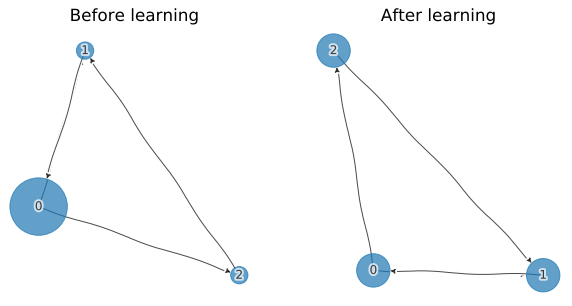

array([[0.27272727],
       [0.27272728],
       [0.27272726]])

In [5]:
G,T = get_sample_graph()
opinion = np.array([1,0,0]).reshape((-1,1))
final_opinion = opinion_spreading(G,opinion,T=T,max_iters = 1000,tol = 1e-15)
show_opinion_spreading(G,opinion,final_opinion,3000)
final_opinion

Convergence taking 41 iterations.


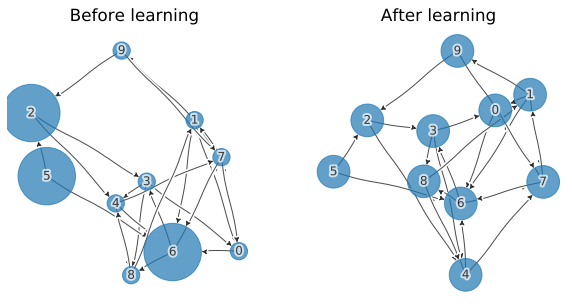

In [13]:
G = nx.erdos_renyi_graph(10,0.3,directed=True)
opinion = random_opinion(G,3)
final_opinion = opinion_spreading(G,opinion,T=None,max_iters = 1000,tol = 1e-7)
show_opinion_spreading(G,opinion,final_opinion,3000)

**Unconvergence case**

Unable to converge


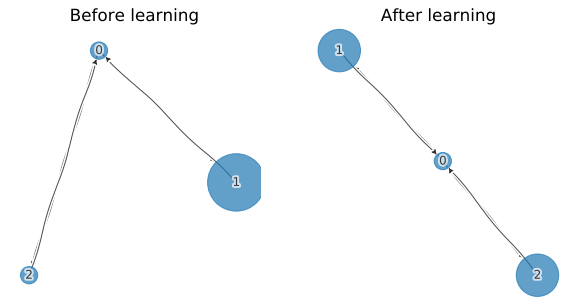

Exception: ignored

In [14]:
G,T = get_divert_graph()
opinion = random_opinion(G,1)
final_opinion = opinion_spreading(G,initiators = 1)
show_opinion_spreading(G,opinion,final_opinion,3000)

G,T = get_divert_graph()
opinion = random_opinion(G,2)
final_opinion = opinion_spreading(G,initiators = 2,raise_on_diverge = True)
show_opinion_spreading(G,opinion,final_opinion,3000)

### Stochastic Matrix - $T$

**Matrix multiplication take huge RAM, to solve this, using Perron Forbenius throey**


*A stochastic matrix is :*
- Non-negative
- Irreduciblee
- Aperiodic

**Solution: left eigenvector problem:**
- $\pi T = \pi \lambda$
- $(\pi_{0},\pi_{1},……\pi_{n})$ -influence vector, power of each node to influence others

**Limiting belief**    
- $p(t) = \lim\limits_{t \to \infty} T^t p(0) = \Pi  p(0) = \sum \limits _{i} \pi_{i} p_{i}(0)$
- For each node: power of influence * initial belief = contribution to concesus
- $\Pi$ only dependes on the belief network structure.

*Not only cares about the final concesus belief, but also the influence of each person*





In [0]:
def opinion_spread_eig(G,T = None,opinion = None,initiators = 3):

    '''
        Compute eigen vectors and eigenvalues of learning matrix T
        Got a exact solution of DeGroot model

        Parameters:
        --------
            G: networkx Graph
            T: leearning matrix
            opinion: opinion vector - column vector
            initiators: used to construct opinion

        Returns:
        --------
            first largest eigenvalue corresponding eigenvector - extract 1st value - float
    '''

    A = np.array(nx.adj_matrix(G).todense())

    # learning / influence matrix
    if T is None:
        T = random_influence(A)

    # opinion vector
    if opinion is None:
        opinion = random_opinion(G,initiators)


    # eigen problem solution
    eigenvalues, eigenvectors = np.linalg.eig(T.T)
    ind = eigenvalues.argsort()
    largest = np.array(eigenvectors[:, ind[-1]]).flatten().real
    norm = float(largest.sum())
    influence_vector = largest / norm
    return (np.dot(influence_vector, opinion) * np.ones(A.shape[0])).reshape((-1,1)), influence_vector

**Matrix multiplication**

Convergence taking 25 iterations.


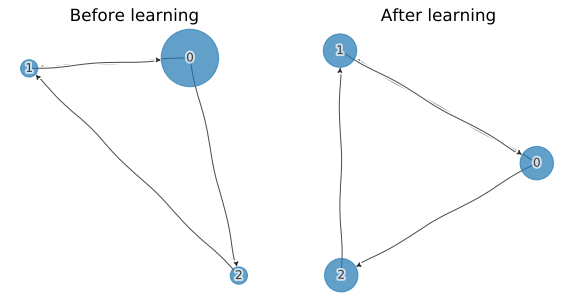

array([[0.27272727],
       [0.27272728],
       [0.27272726]])

In [79]:
G,T = get_sample_graph()
opinion = np.array([1,0,0]).reshape((-1,1))
final_opinion = opinion_spreading(G,opinion,T=T,max_iters = 1000,tol = 1e-15)
show_opinion_spreading(G,opinion,final_opinion,3000)
final_opinion

**Eigen problem**

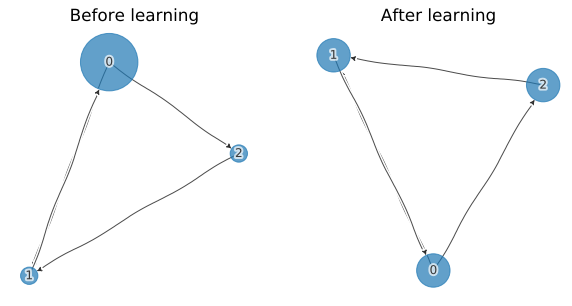

array([[0.27272727],
       [0.27272727],
       [0.27272727]])

In [80]:
final_opinion,infl = opinion_spread_eig(G,T,opinion)
show_opinion_spreading(G,opinion,final_opinion,3000)
final_opinion

**Influence vector**

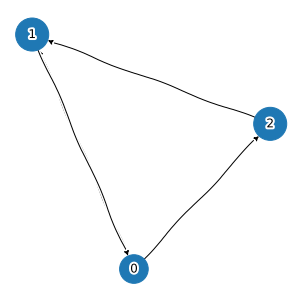

In [86]:
figsize(4,4)
nx.draw(G,node_size = infl * 3000,with_labels = True)

**Exmaple: learning on random graph**

In [0]:
G = nx.erdos_renyi_graph(15,0.3,directed=True)
opinion = random_opinion(G)
T = random_influence(np.array(nx.adj_matrix(G).todense()))

**Matrix multiplication**

Convergence taking 49 iterations.


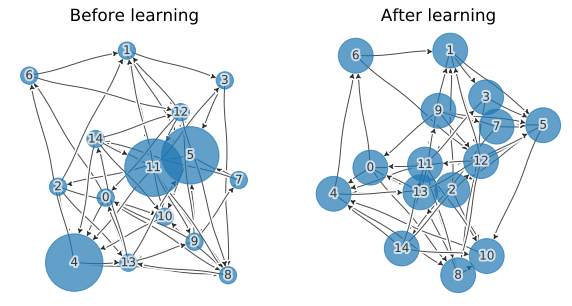

CPU times: user 1.01 s, sys: 380 ms, total: 1.39 s
Wall time: 958 ms


In [89]:
%%time
final_opinion = opinion_spreading(G,opinion,T=T,max_iters = 1000,tol = 1e-20)
show_opinion_spreading(G,opinion,final_opinion,3000)
final_opinion

**Eigenvector problem**

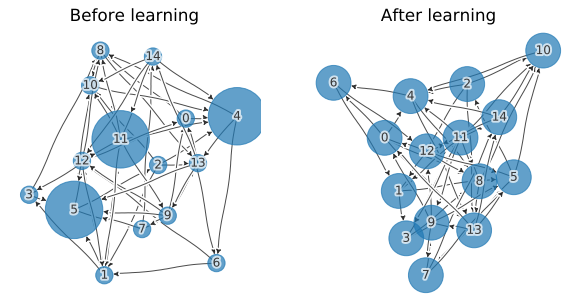

CPU times: user 1 s, sys: 392 ms, total: 1.39 s
Wall time: 953 ms


In [91]:
%%time
final_opinion,infl = opinion_spread_eig(G,T,opinion)
show_opinion_spreading(G,opinion,final_opinion,3000)
final_opinion

**Influence vector**

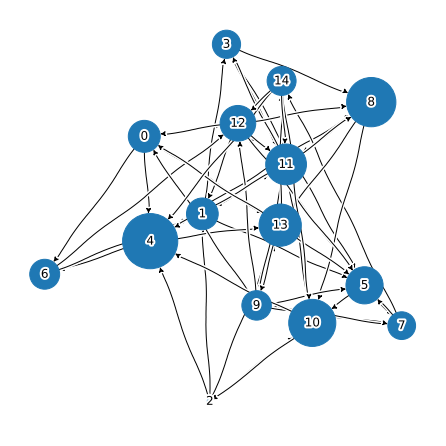

In [97]:
figsize(6,6)
nx.draw(G,node_size = infl * 20000,with_labels = True)

### Notes

- $T_{ij}$ is adjacency matrix carring weights, on all edges.
- These weights are how much a person listens to each other.

*TO BE CONTINUED*